In [181]:
import tensorflow as tf
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Traffic Sign Recognition Classifier

In [182]:
#Loading Data traffic-signs-data

# download data http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


training = "traffic-signs-data/train.p"
testing = "traffic-signs-data/test.p"


with open(training, mode='rb') as file:
    train = pickle.load(file) 

with open(testing, mode='rb') as file:
    test = pickle.load(file)



In [183]:
X_tr, Y_tr = train['features'], train['labels']
X_te, Y_te = test['features'], test['labels']
classes = len(set(Y_tr))


print ("Training iputs shape: {}".format(X_tr.shape))
print ("Training labels shape: {}".format(Y_tr.shape))

print ("Testing iputs shape: {}".format(X_te.shape))
print ("Testing labels shape: {}".format(Y_te.shape))
print ("Number of classes {}". format(classes))

Training iputs shape: (39209, 32, 32, 3)
Training labels shape: (39209,)
Testing iputs shape: (12630, 32, 32, 3)
Testing labels shape: (12630,)
Number of classes 43


# Visualizing Data

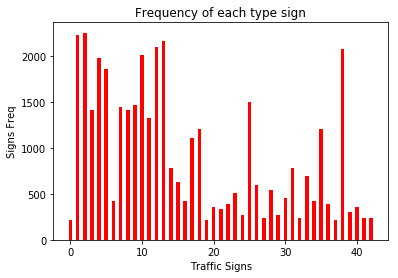

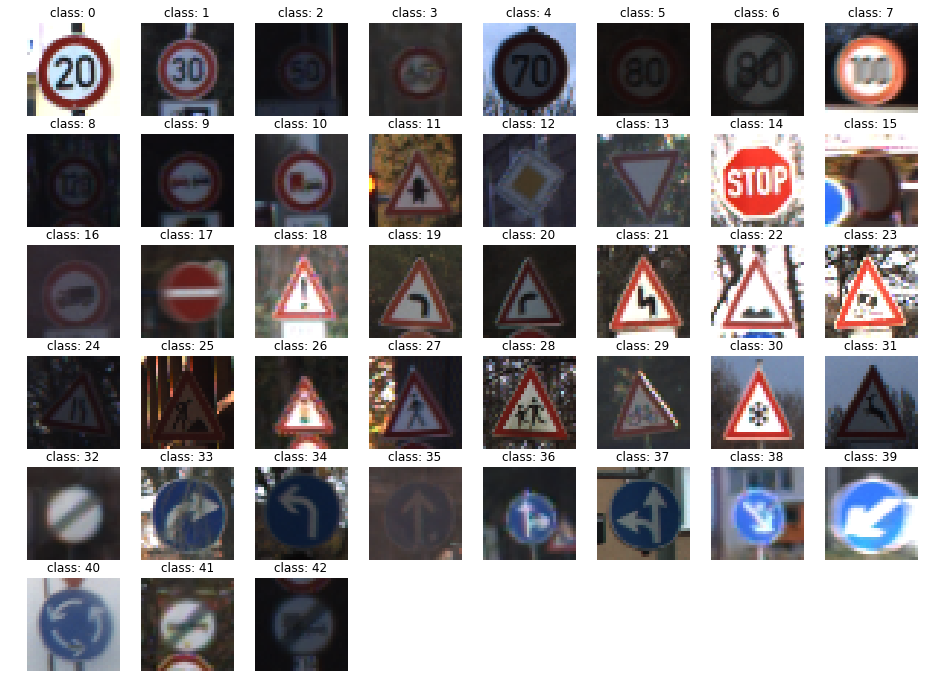

In [184]:
import random as rd

fig, ax = plt.subplots()
ax.bar(range(classes), np.bincount(Y_tr), 0.5, color='r')
ax.set_xlabel('Traffic Signs')
ax.set_ylabel('Signs Freq')
ax.set_title('Frequency of each type sign')
plt.show()

plt.figure(figsize=(16, 16))
for i in range(classes):
    j = rd.choice(np.where(Y_tr == i)[0])
    plt.subplot(8, 8, i + 1)
    plt.axis('off')
    plt.title('class: {}'.format(i))
    plt.imshow(X_tr[j])




In [185]:
def weights(shape):
    weight_var = tf.truncated_normal(shape, mean=0, stddev=0.1)
    return tf.Variable(weight_var)

def biases(shape):
    bias_var = tf.zeros(shape=shape)
    return tf.Variable(bias_var)

def conv2d(x, w, bias, strides=1):
    stride = [1, strides, strides, 1]
    conv = tf.nn.conv2d(x, w, stride, padding='SAME')
    conv_bias = tf.nn.bias_add(conv, bias)
    activation = tf.nn.relu(conv_bias)
    return activation

def maxpool2d(x, k=2):
    ksize_stride = [1, k, k, 1]
    return tf.nn.max_pool(x, ksize=ksize_stride, strides=ksize_stride, padding='SAME')




In [208]:
def cnn(x):
    weights1 = weights([5, 5, 3, 6])
    bias1 = biases([6])
    conv1 = conv2d(x, weights1, bias1)
    
    conv1 = maxpool2d(conv1)
    
    
    weights2 = weights([5, 5, 6, 16])
    bias2 = biases([16])
    conv2 = conv2d(conv1, weights2, bias2)
    
    conv2 = maxpool2d(conv2)
    
    # fully connected layer 1
    fc_w1 = weights([8*8*16, 128])
    fc_b1 = biases([128])
    fc1 = tf.reshape(conv2, [-1, 8*8*16])
    fc1 = tf.matmul(fc1, fc_w1) + fc_b1
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, 0.8)
    
    # fully connected layer 2
    fc_w2 = weights([128, 84])
    fc_b2 = biases([84])
    fc2 = tf.matmul(fc1, fc_w2) + fc_b2
    fc2 = tf.nn.relu(fc2)
    #fc2 = tf.nn.dropout(fc2, 0.8)
    
    # fully connected layer 3
    fc_w3 = weights([84, classes])
    fc_b3 = biases([classes])
    fc3 = tf.matmul(fc2, fc_w3) + fc_b3
    return fc3
    
    
    
    
    
    

In [209]:
def train(X_batch, Y_batch):
    total_loss = 0
    total_acc = 0
    samples = len(X_batch)
    sess = tf.get_default_session()
    for offset in range(0, samples, batch_size):
        end = offset+batch_size
        xs_batch, ys_batch = X_batch[offset:end], Y_batch[offset:end]
        loss_, acc = sess.run([loss, accuracy], feed_dict={x:xs_batch, y:ys_batch})
        total_loss += (float(loss_)*xs_batch.shape[0])
        total_acc += (float(acc)*xs_batch.shape[0])

    return (total_loss)/samples, (total_acc)/samples
    
    

# Build Model

In [210]:

tf.reset_default_graph()

epochs = 10
batch_size = 128
deph = classes
learning_rate = 1e-3

x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3))
y = tf.placeholder(tf.int32, shape=(None))

y_hot = tf.one_hot(y, deph)


In [211]:
logits = cnn(x)
step = tf.Variable(0, trainable=False)
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_hot))
with tf.name_scope("train_step"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='optimizer').minimize(loss)

prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_hot, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))


In [228]:
from sklearn.utils import shuffle

train_loss = []
train_acc = []
val_loss = []
val_acc = []
test_loss_ = []
test_acc_ = []

samples = len(X_tr)
print("Initializing Training")
try:
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        for epoch in range(epochs):
            X_tr, Y_tr = shuffle(X_tr, Y_tr)
            for offset in range(0, samples, batch_size):
                end = offset+batch_size
                xs_batch, ys_batch = X_tr[offset:end], Y_tr[offset:end]
                loss_, _, acc_ = sess.run([loss, optimizer, accuracy], feed_dict={x: xs_batch, y: ys_batch})
                train_loss.append(loss_)
                train_acc.append(acc_)
            validation_loss, validation_acc = train(X_train, Y_train)
            val_loss.append(validation_loss)
            val_acc.append(validation_acc)
            print("EPOCH {}".format(epoch + 1))
            print ("Validation Loss = {:.3f} and Validation Accuracy = {:.3f} %".format(validation_loss, 100 *validation_acc))
        test_loss, test_acc = train(X_te, Y_te)
        test_loss_.append(test_loss)
        test_acc_.append(test_acc)
        print ("Test Loss {} and Test Accuracy {:.3f} %".format(test_loss, 100 *test_acc))
except KeyboardInterrupt:
    print('Training interrupted')

Initializing Training
EPOCH 1
Validation Loss = 2.004 and Validation Accuracy = 40.787 %
EPOCH 2
Validation Loss = 1.405 and Validation Accuracy = 56.349 %
EPOCH 3
Validation Loss = 0.983 and Validation Accuracy = 69.504 %
EPOCH 4
Validation Loss = 0.748 and Validation Accuracy = 76.041 %
EPOCH 5
Validation Loss = 0.625 and Validation Accuracy = 80.089 %
EPOCH 6
Validation Loss = 0.488 and Validation Accuracy = 84.338 %
EPOCH 7
Validation Loss = 0.470 and Validation Accuracy = 85.251 %
EPOCH 8
Validation Loss = 0.332 and Validation Accuracy = 89.370 %
EPOCH 9
Validation Loss = 0.325 and Validation Accuracy = 89.763 %
EPOCH 10
Validation Loss = 0.264 and Validation Accuracy = 91.594 %
Test Loss 0.7984467739730436 and Test Accuracy 81.615 %


# Plotting Progress

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


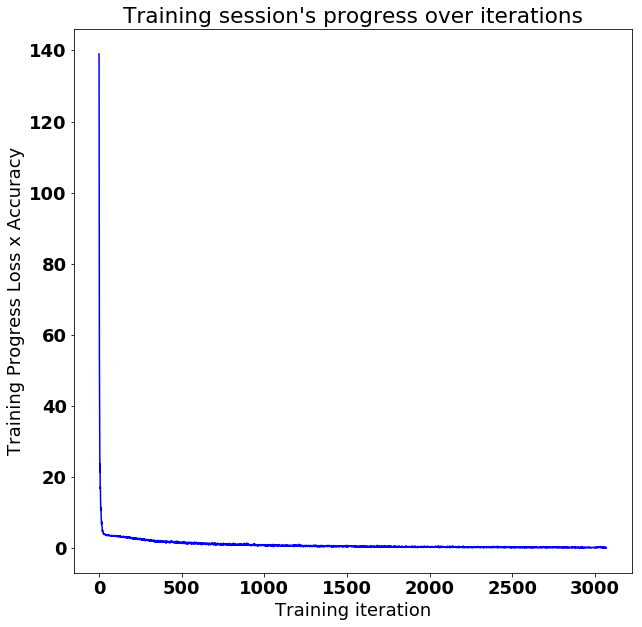

In [226]:

plt.title("Training session's progress over iterations")
plt.plot(train_loss, 'b-', label='Train Loss')
#plt.plot(train_acc, 'g--', label='Accuracy')
plt.xlabel('Training iteration')
plt.ylabel('Training Progress Loss x Accuracy')
plt.show()



/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


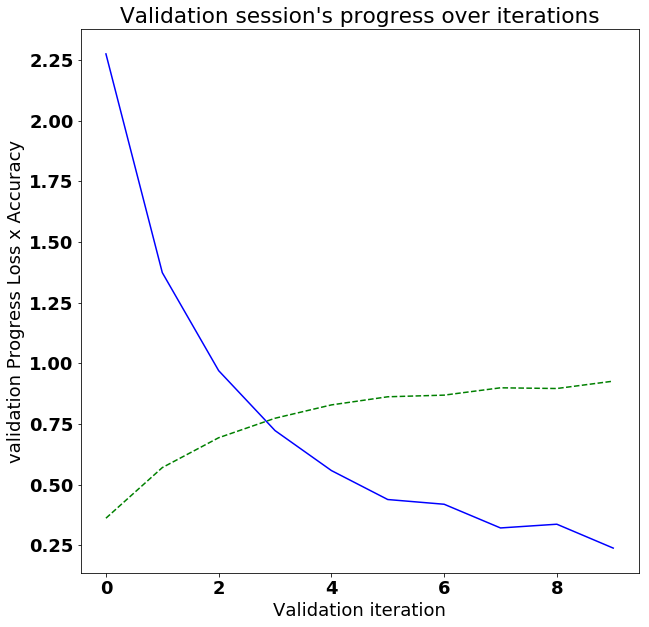

In [225]:
width = 10
height = 10
plt.figure(figsize=(width, height))

plt.title("Validation session's progress over iterations")
plt.plot(val_loss, 'b-', label='Train Loss')
plt.plot(val_acc, 'g--', label='Accuracy')
plt.xlabel('Validation iteration')
plt.ylabel('validation Progress Loss x Accuracy')
plt.show()

